In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import os


from utils import visualization_utils as vis_util

from utils import label_map_util
# import detection_inference 


/home/jinhuyinhu99513/develop/utils/visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jinhuyinhu99513/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jinhuyinhu99513/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jinhuyinhu99513/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File 

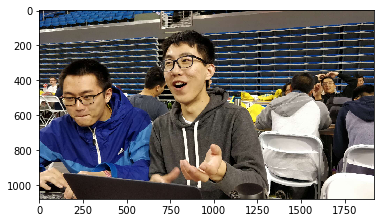

In [2]:
# Load image
image_path = "image_test.jpeg"
image = Image.open(image_path)
image.load()

# Convert image to numpy array
image_np = np.asarray(image, dtype="int32")

# Show image
plt.imshow(image_np)

In [3]:
# Expand image dimension to shape: [1, None, None, 3]
#image_np_expanded = np.expand_dims(image_np, axis=0)

In [4]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes',
      ]:
        tensor_name = key + ':0'
        #tensor_name = key
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
        
        
        
      image_tensor = graph.get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      
    
  return output_dict

In [5]:
# Load frozen graph from disk
def load_graph(frozen_graph_filename):
    graph = tf.Graph()
      
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name="")
        
    return graph


In [6]:
# Load frozen graph from disk for inference
frozen_graph_filename = "frozen_inference_graph.pb"
detection_graph = load_graph(frozen_graph_filename)

In [7]:
# Intermediate Test

# Try get input image_tensor
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

In [8]:
# Actual inference (object detection)
output_dict = run_inference_for_single_image(image_np, detection_graph)

In [9]:
# Alternative solution
class TrafficLightClassifier(object):
    def __init__(self):
        PATH_TO_MODEL = 'frozen_inference_graph.pb'
        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            # Works up to here.
            with tf.gfile.GFile(PATH_TO_MODEL, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')
                
                
            self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
            self.d_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
            self.d_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
            self.d_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
            self.num_d = self.detection_graph.get_tensor_by_name('num_detections:0')
        self.sess = tf.Session(graph=self.detection_graph)
        
    
    def get_classification(self, img):
        # Bounding Box Detection.
        with self.detection_graph.as_default():
            # Expand dimension since the model expects image to have shape [1, None, None, 3].
            img_expanded = np.expand_dims(img, axis=0)  
            (boxes, scores, classes, num) = self.sess.run(
                [self.d_boxes, self.d_scores, self.d_classes, self.num_d],
                feed_dict={self.image_tensor: img_expanded})
        return boxes, scores, classes, num

In [10]:
detection_graph = TrafficLightClassifier();

(boxes, scores, classes, num) = detection_graph.get_classification(image_np)

In [11]:
# Convert output type
num = int(num[0])
classes = classes[0].astype(np.uint8)
boxes = boxes[0]
scores = scores[0]

#####################################

14
[1 2 2 2 1 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[0.4570572  0.67566115 0.5577233  0.7278625 ]
 [0.5347028  0.5148728  0.8743497  0.5840579 ]
 [0.4805974  0.3247006  0.72396094 0.35459712]
 [0.5716924  0.1546541  0.9380763  0.22497462]
 [0.50602335 0.37634483 0.7025515  0.57175285]
 [0.4661253  0.3221057  0.6677294  0.35018957]
 [0.6083394  0.37871474 1.         0.44543287]
 [0.6006947  0.365221   0.9911402  0.42352664]
 [0.5090157  0.19283119 0.76216245 0.2323818 ]
 [0.44420737 0.41993055 0.6276867  0.44288146]
 [0.4403006  0.7761414  0.61799246 0.7996423 ]
 [0.4840884  0.2768508  0.78978205 0.30737576]
 [0.5791737  0.10043315 0.87168777 0.14864878]
 [0.46886954 0.46790045 0.58943725 0.48390898]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.    

In [9]:
# List of strings used to add correct label for each box
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')
NUM_CLASSES = 90
IMAGE_SIZE = (20, 16)

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

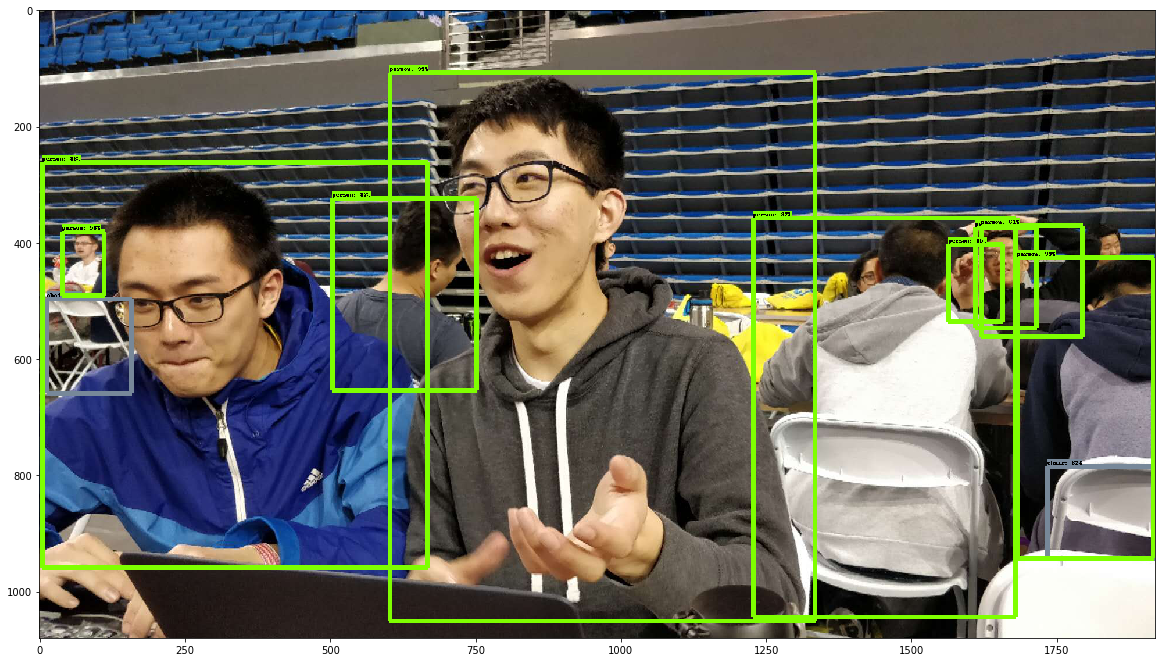

In [10]:
# Visualization of the result
vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      None,
      use_normalized_coordinates=True,
      line_thickness=8)

plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)

In [11]:
print(label_map)

item {
  name: "/m/01g317"
  id: 1
  display_name: "person"
}
item {
  name: "/m/0199g"
  id: 2
  display_name: "bicycle"
}
item {
  name: "/m/0k4j"
  id: 3
  display_name: "car"
}
item {
  name: "/m/04_sv"
  id: 4
  display_name: "motorcycle"
}
item {
  name: "/m/05czz6l"
  id: 5
  display_name: "airplane"
}
item {
  name: "/m/01bjv"
  id: 6
  display_name: "bus"
}
item {
  name: "/m/07jdr"
  id: 7
  display_name: "train"
}
item {
  name: "/m/07r04"
  id: 8
  display_name: "truck"
}
item {
  name: "/m/019jd"
  id: 9
  display_name: "boat"
}
item {
  name: "/m/015qff"
  id: 10
  display_name: "traffic light"
}
item {
  name: "/m/01pns0"
  id: 11
  display_name: "fire hydrant"
}
item {
  name: "/m/02pv19"
  id: 13
  display_name: "stop sign"
}
item {
  name: "/m/015qbp"
  id: 14
  display_name: "parking meter"
}
item {
  name: "/m/0cvnqh"
  id: 15
  display_name: "bench"
}
item {
  name: "/m/015p6"
  id: 16
  display_name: "bird"
}
item {
  name: "/m/01yrx"
  id: 17
  display_name: "cat

In [12]:
categories = label_map_util.convert_label_map_to_categories(label_map, NUM_CLASSES)
category_index = label_map_util.create_category_index(categories)

In [13]:
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

In [14]:
n = 2
output_dict["detection_scores"][n]

0.98830754